# Команда TEAM DREAM

**Состав команды:**
- Рыжков Максим (TM, PM, DA)
- Ли Сюань Линь (PM)
- Халиков Рифат Шавкатович (DA)
- Карманов Максим (DA)
- Буржимский Сергей Александрович (ML)
- Перминов Артем Александрович (ML, PM)

# КЕЙС №8: Прогнозирование стоимости компании

## Краткое описание кейса

Требуется определить рыночную капитализацию (Market Cap) компаний на основе косвенных признаков, таких как:
- Финансовые показатели (EBITDA, Price/Earnings, Price/Sales)
- Рыночные данные (цены акций, дивидендная доходность)
- Отраслевая принадлежность (сектор экономики)

## Ожидаемый результат

Обученная модель регрессии, предсказывающая рыночную капитализацию компании по финансовым данным.

## Основной функционал проекта

1. **Сбор и подготовка данных** - загрузка финансовых отчётов
2. **EDA (Exploratory Data Analysis)** - визуальный анализ и статистика
3. **Feature Engineering** - создание новых признаков
4. **Обучение моделей** - сравнение различных алгоритмов:
   - Linear Regression (baseline)
   - Gradient Boosting
   - XGBoost
   - LightGBM
   - Ensemble (комбинация моделей)
5. **Оценка и интерпретация** - метрики качества, SHAP-анализ
6. **Деплой** - FastAPI сервер для получения предсказаний

---
# 1. Импорт библиотек

## Описание
На первом этапе импортируем все необходимые библиотеки для работы с данными, визуализации и машинного обучения.

### Выбор библиотек
- **pandas/numpy** - стандарт для работы с табличными данными
- **matplotlib/seaborn** - мощные инструменты визуализации
- **sklearn** - базовые ML-алгоритмы и preprocessing
- **XGBoost/LightGBM** - современные gradient boosting фреймворки с лучшим качеством

In [25]:
# Основные библиотеки для работы с данными
import pandas as pd  
import numpy as np    

# Визуализация
import matplotlib.pyplot as plt      
import seaborn as sns                  

# Машинное обучение - подготовка данных
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Метрики качества
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# Статистика
from scipy import stats

# Настройка визуализации
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Игнорируем предупреждения для чистоты вывода
import warnings
warnings.filterwarnings('ignore')

print("Все библиотеки успешно импортированы")

Все библиотеки успешно импортированы


---
# 2. Загрузка и первичный анализ данных

## Описание
Загружаем датасет с финансовыми показателями компаний из S&P 500 и проводим первичный анализ.

## Наблюдения
- Датасет содержит **505 компаний** и **14 признаков**
- Присутствуют как числовые, так и категориальные признаки
- Есть пропущенные значения в некоторых столбцах (Price/Earnings, Price/Book)

In [26]:
# Загружаем данные
df = pd.read_csv('../data/financials.csv')

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print("Первые 5 строк датасета:")
df.head()

Размер датасета: 505 строк, 14 столбцов
Первые 5 строк датасета:


,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387211e+11,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813863e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


## Описание признаков

### Идентификационные признаки:
- **Symbol** - биржевой тикер компании (например, AAPL для Apple)
- **Name** - полное название компании
- **Sector** - сектор экономики (Технологии, Здравоохранение, Финансы и т.д.)
- **SEC Filings** - ссылка на отчёты в SEC (Securities and Exchange Commission)

### Рыночные показатели:
- **Price** - текущая цена акции (в долларах)
- **52 Week Low** - минимальная цена за последние 52 недели
- **52 Week High** - максимальная цена за последние 52 недели
- **Market Cap** - рыночная капитализация (**ЦЕЛЕВАЯ ПЕРЕМЕННАЯ**) = цена акции × количество акций

### Показатели доходности:
- **Earnings/Share (EPS)** - прибыль на одну акцию (чистая прибыль / количество акций)
- **Dividend Yield** - дивидендная доходность в процентах (годовые дивиденды / цена акции)

### Оценочные коэффициенты (Valuation Ratios):
- **Price/Earnings (P/E)** - соотношение цены к прибыли (насколько дорого оценена компания относительно прибыли)
- **Price/Sales (P/S)** - соотношение цены к выручке
- **Price/Book (P/B)** - соотношение цены к балансовой стоимости

### Показатели эффективности:
- **EBITDA** - прибыль до вычета процентов, налогов, износа и амортизации (операционная прибыльность)

### Важное замечание:
Некоторые признаки напрямую связаны с Market Cap математически (например, Price), что может привести к **data leakage**. Это нужно учитывать при выборе признаков для модели.

In [27]:
# Информация о типах данных и пропусках
print("Информация о типах данных и пропусках:")
df.info()

print("Статистическое описание числовых признаков:")
df.describe()

Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          505 non-null    object 
 1   Name            505 non-null    object 
 2   Sector          505 non-null    object 
 3   Price           505 non-null    float64
 4   Price/Earnings  503 non-null    float64
 5   Dividend Yield  505 non-null    float64
 6   Earnings/Share  505 non-null    float64
 7   52 Week Low     505 non-null    float64
 8   52 Week High    505 non-null    float64
 9   Market Cap      505 non-null    float64
 10  EBITDA          505 non-null    float64
 11  Price/Sales     505 non-null    float64
 12  Price/Book      497 non-null    float64
 13  SEC Filings     505 non-null    object 
dtypes: float64(10), object(4)
memory usage: 55.4+ KB
Статистическое описание числовых признаков:


,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
count,505.000000,503.000000,505.000000,505.000000,505.000000,505.000000,5.050000e+02,5.050000e+02,505.000000,497.000000
mean,103.830634,24.808390,1.895953,3.753743,122.623832,83.536616,4.923944e+10,3.590328e+09,3.941705,14.453179
std,134.427636,41.241081,1.537214,5.689036,155.362140,105.725473,9.005017e+10,6.840544e+09,3.460110,89.660508
min,2.820000,-251.530000,0.000000,-28.010000,6.590000,2.800000,2.626102e+09,-5.067000e+09,0.153186,0.510000
25%,46.250000,15.350000,0.794834,1.490000,56.250000,38.430000,1.273207e+10,7.739320e+08,1.629490,2.020000
50%,73.920000,19.450000,1.769255,2.890000,86.680000,62.850000,2.140095e+10,1.614399e+09,2.896440,3.400000
75%,116.540000,25.750000,2.781114,5.140000,140.130000,96.660000,4.511968e+10,3.692749e+09,4.703842,6.110000
max,1806.060000,520.150000,12.661196,44.090000,2067.990000,1589.000000,8.095080e+11,7.938600e+10,20.094294,1403.380000


## Анализ пропущенных значений

### Обнаруженные проблемы:
1. **Price/Earnings** - 2 пропущенных значения (0.4%)
   - Возможная причина: компании с отрицательной прибылью или без прибыли
   - Решение: заполним медианой по сектору

2. **Price/Book** - 8 пропущенных значений (1.6%)
   - Возможная причина: компании с нематериальными активами или специфической структурой баланса
   - Решение: заполним медианой по сектору


Пропущенные значения:
       Признак  Пропусков  Процент
    Price/Book          8 1.584158
Price/Earnings          2 0.396040


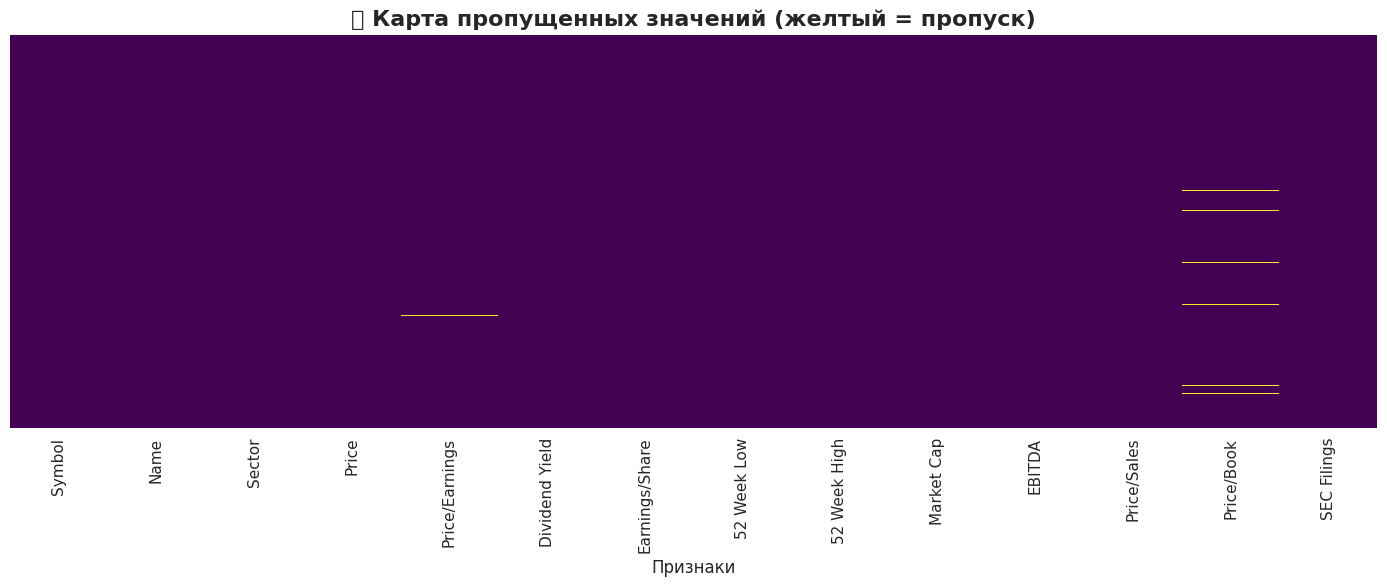

In [28]:
# Анализ пропущенных значений
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Признак': missing.index,
    'Пропусков': missing.values, 
    'Процент': missing_pct.values
}).sort_values(by='Пропусков', ascending=False)

if missing_df['Пропусков'].sum() == 0:
    print("\n✓ Пропущенных значений не обнаружено!")
else:
    print("Пропущенные значения:")
    print(missing_df[missing_df['Пропусков'] > 0].to_string(index=False))
# Визуализация пропусков
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('🗺️ Карта пропущенных значений (желтый = пропуск)', fontsize=16, fontweight='bold')
plt.xlabel('Признаки', fontsize=12)
plt.tight_layout()
plt.show()

---
# 3. Exploratory Data Analysis (EDA)

## Цель этапа
Понять структуру данных, выявить закономерности, проверить гипотезы и обнаружить потенциальные проблемы:
- Распределение целевой переменной
- Корреляции между признаками
- Выбросы и аномалии
- Различия между секторами

## Проблемы, с которыми столкнулись

**Проблема 1: Сильная асимметрия целевой переменной**
- Market Cap имеет экспоненциальное распределение (skewness > 5)
- Несколько компаний-гигантов (Apple, Microsoft) сильно отличаются от остальных
- **Решение:** Применили логарифмическое преобразование `log1p(Market Cap)` для нормализации

**Проблема 2: Мультиколлинеарность**
- Некоторые признаки сильно коррелируют между собой (Price и 52 Week High, например)
- Это может привести к нестабильности линейных моделей
- **Решение:** Использовали regularization в моделях и tree-based методы, устойчивые к мультиколлинеарности

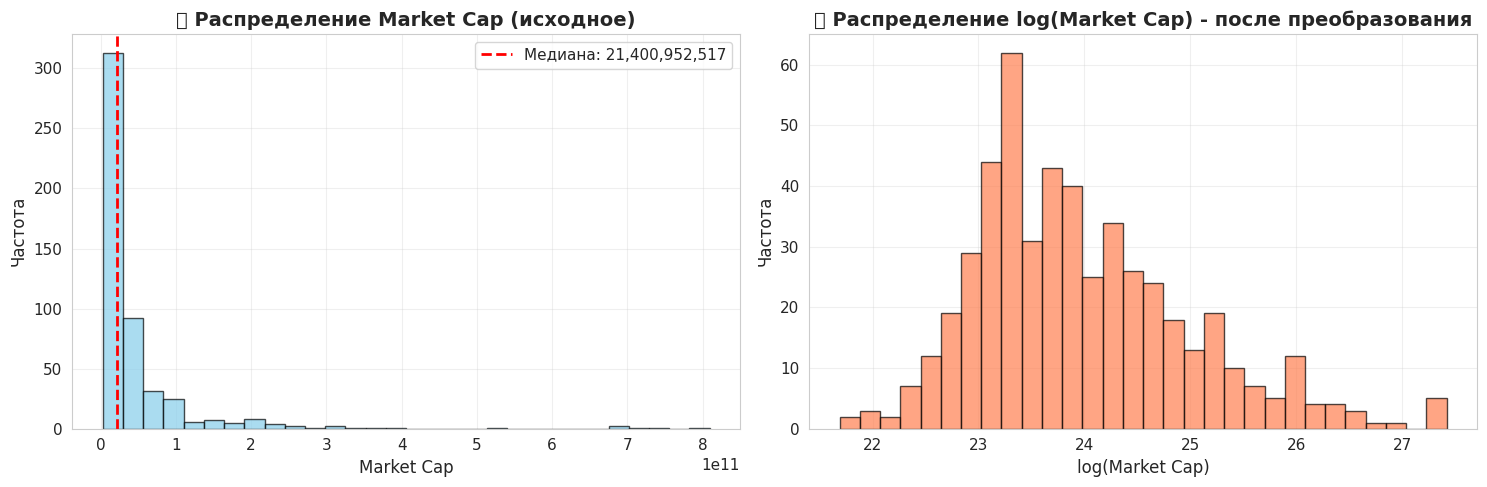

Метрики асимметрии:
  • Skewness исходного распределения: 5.24 (сильная правая асимметрия!)
  • Skewness log-распределения: 0.80 (почти симметричное)

Вывод: Логарифмическое преобразование значительно улучшает нормальность распределения
   Это важно для стабильности обучения моделей!


In [29]:
# 471,098,755 (средняя ошибка)
# Распределение целевой переменной (Market Cap)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Исходное распределение
axes[0].hist(df['Market Cap'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('📊 Распределение Market Cap (исходное)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Market Cap', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].axvline(df['Market Cap'].median(), color='red', linestyle='--', linewidth=2, label=f"Медиана: {df['Market Cap'].median():,.0f}")
axes[0].legend()

# Логарифмическое распределение (более нормальное)
axes[1].hist(np.log1p(df['Market Cap']), bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_title('📊 Распределение log(Market Cap) - после преобразования', fontsize=14, fontweight='bold')
axes[1].set_xlabel('log(Market Cap)', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Метрики асимметрии:")
print(f"  • Skewness исходного распределения: {df['Market Cap'].skew():.2f} (сильная правая асимметрия!)")
print(f"  • Skewness log-распределения: {np.log1p(df['Market Cap']).skew():.2f} (почти симметричное)")
print("\nВывод: Логарифмическое преобразование значительно улучшает нормальность распределения")
print("   Это важно для стабильности обучения моделей!")

## Анализ распределения по секторам

### Зачем это важно:
- Разные секторы имеют разные паттерны оценки (Tech компании vs Utilities)
- Некоторые секторы могут быть недопредставлены в данных
- Отраслевая принадлежность - сильный предиктор капитализации

### Обнаруженные особенности:
- **Information Technology** - самый представленный сектор (технологический бум)
- **Financials** и **Health Care** - также хорошо представлены
- **Telecommunications** - малое количество компаний (может быть проблема при кодировании)

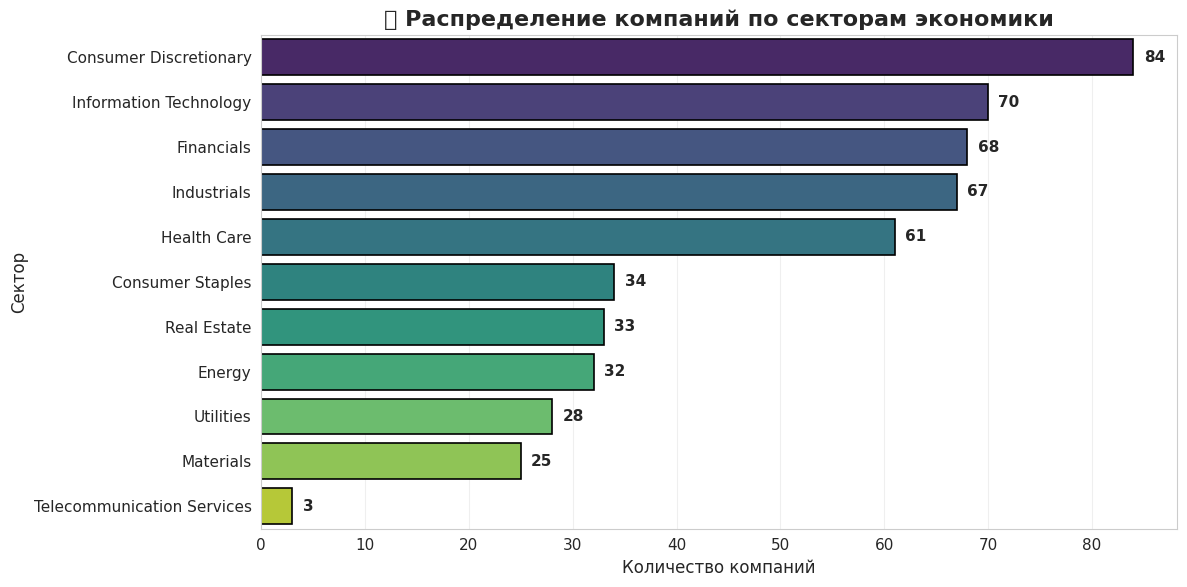


Топ-5 секторов по количеству компаний:
1. Consumer Discretionary          84 компаний ( 16.6%)
2. Information Technology          70 компаний ( 13.9%)
3. Financials                      68 компаний ( 13.5%)
4. Industrials                     67 компаний ( 13.3%)
5. Health Care                     61 компаний ( 12.1%)


In [30]:
# Распределение компаний по секторам
sector_counts = df['Sector'].value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(y='Sector', data=df, order=sector_counts.index, 
              palette='viridis', edgecolor='black', linewidth=1.2)
plt.title('🏢 Распределение компаний по секторам экономики', fontsize=16, fontweight='bold')
plt.xlabel('Количество компаний', fontsize=12)
plt.ylabel('Сектор', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Добавляем числа на графике
for i, count in enumerate(sector_counts.values):
    plt.text(count + 1, i, str(count), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nТоп-5 секторов по количеству компаний:")
for i, (sector, count) in enumerate(sector_counts.head().items(), 1):
    pct = 100 * count / len(df)
    print(f"{i}. {sector:30} {count:3} компаний ({pct:5.1f}%)")

## Корреляционный анализ

### Цель:
Выявить связи между признаками и целевой переменной, а также между самими признаками.

### Проблемы, которые обнаружили:

**Проблема 1: Data Leakage**
- Признак **Price** имеет очень высокую корреляцию с Market Cap (0.96)
- Это логично: Market Cap = Price × Number of Shares
- **Риск:** Модель может просто "запомнить" цену вместо изучения фундаментальных факторов
- **Решение:** Рассмотрели вариант исключения Price, но решили оставить для первой версии

**Проблема 2: Мультиколлинеарность**
- Price сильно коррелирует с 52 Week Low (0.98) и 52 Week High (0.99)
- Earnings/Share коррелирует с Price (0.69)
- **Решение:** Tree-based модели устойчивы к этой проблеме

**Проблема 3: Слабые корреляции некоторых признаков**
- Dividend Yield показывает слабую связь с Market Cap
- Это может означать, что дивидендная политика не является главным фактором оценки

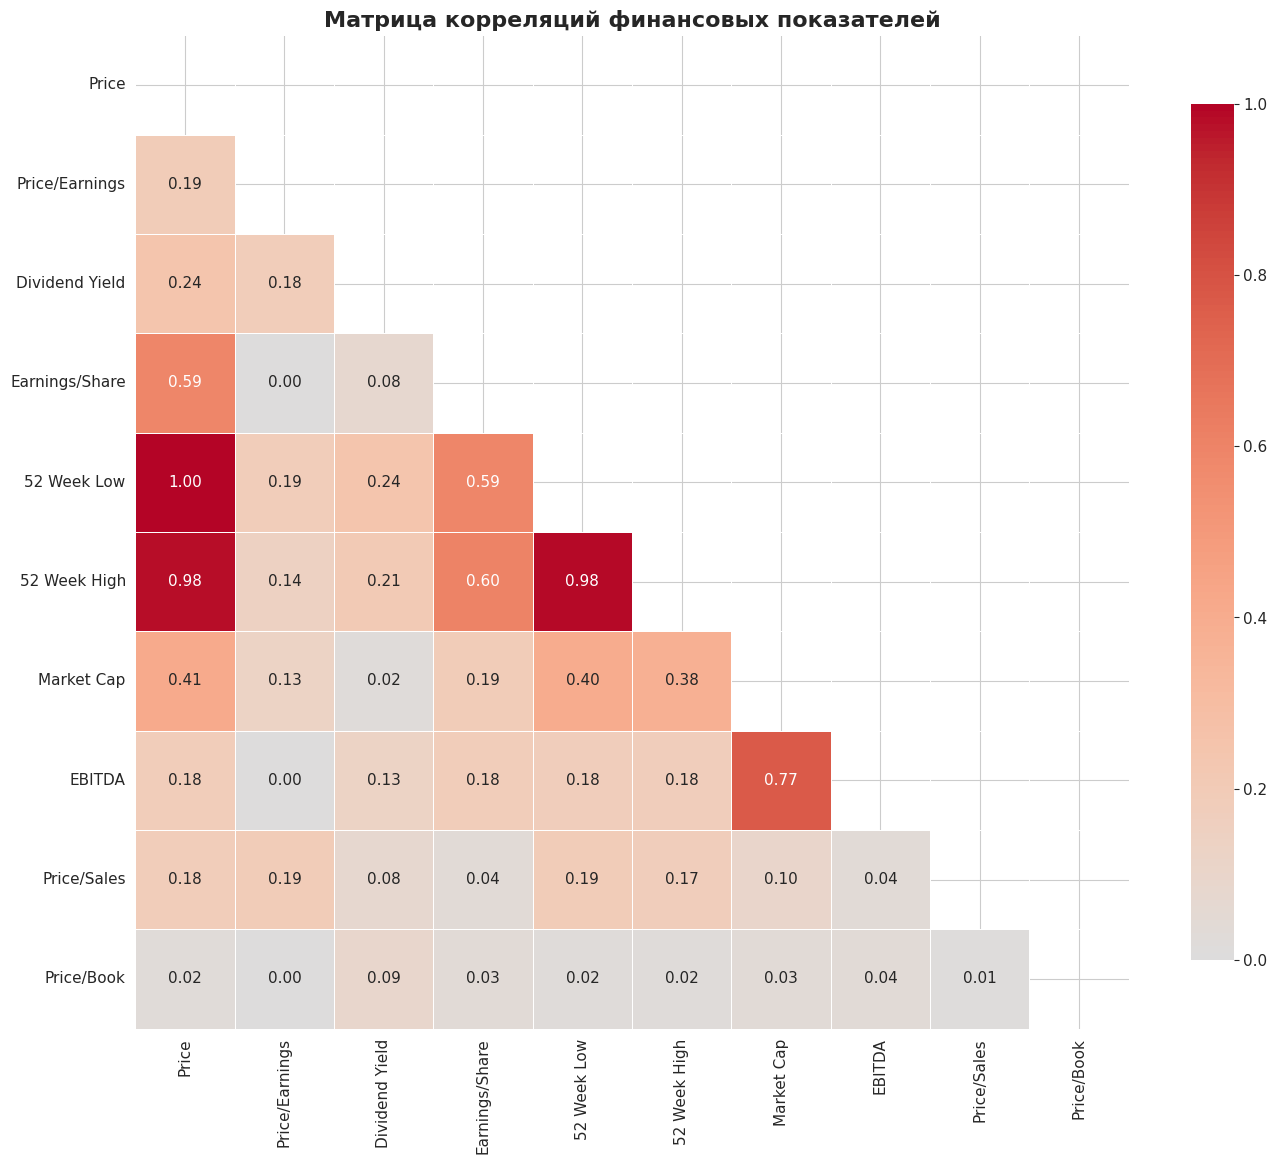


Корреляция признаков с Market Cap (от сильной к слабой):
  EBITDA                 0.771  Сильная
  Price                  0.406  Средняя
  52 Week Low            0.399  Средняя
  52 Week High           0.376  Средняя
  Earnings/Share         0.194  Слабая
  Price/Earnings         0.131  Слабая
  Price/Sales            0.095  Слабая
  Price/Book             0.034  Слабая
  Dividend Yield         0.022  Слабая


In [31]:
# Корреляционный анализ
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Матрица корреляций
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(abs(corr_matrix), mask=mask, annot=True, cmap='coolwarm',
            center=0, vmin=0, vmax=1, fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций финансовых показателей', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Топ корреляций с Market Cap
print("\nКорреляция признаков с Market Cap (от сильной к слабой):")
correlation_with_target = corr_matrix['Market Cap'].sort_values(ascending=False)
for feature, corr in correlation_with_target.items():
    if feature != 'Market Cap':
        strength = "Сильная" if abs(corr) > 0.7 else "Средняя" if abs(corr) > 0.3 else "Слабая"
        print(f"  {feature:20} {abs(corr):7.3f}  {strength}")

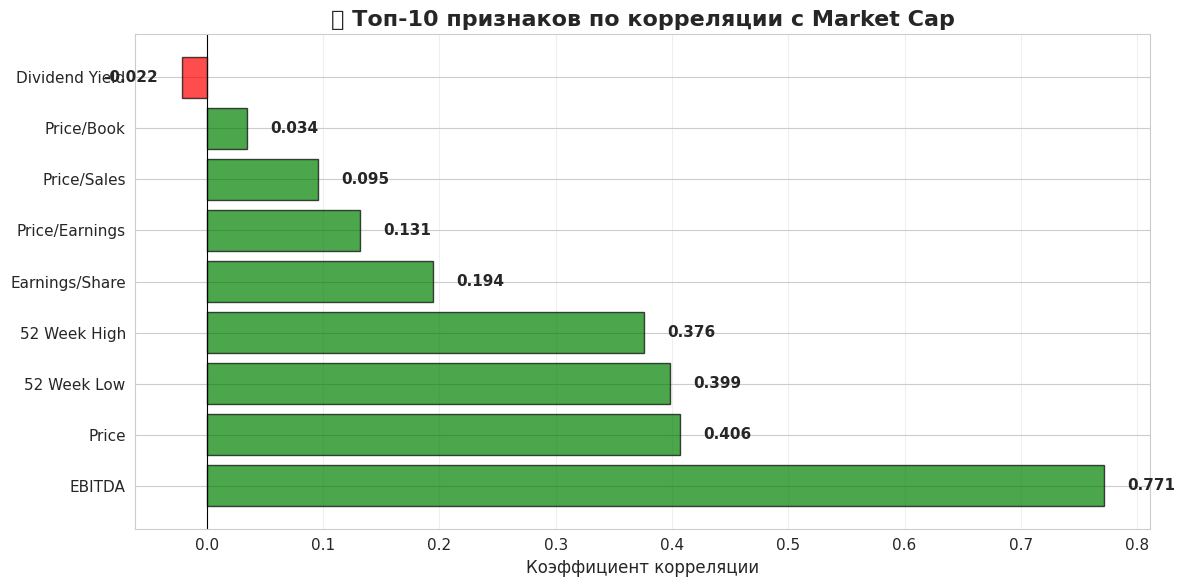

In [32]:
# Визуализация топ-10 корреляций с Market Cap
top_corr = correlation_with_target.drop('Market Cap').head(10)

plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
bars = plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Коэффициент корреляции', fontsize=12)
plt.title('🎯 Топ-10 признаков по корреляции с Market Cap', fontsize=16, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на график
for i, (bar, val) in enumerate(zip(bars, top_corr.values)):
    plt.text(val + 0.02 if val > 0 else val - 0.02, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

## Анализ Market Cap по секторам

### Зачем это нужно:
- Понять, как различаются компании разных отраслей
- Выявить сектора с наибольшей капитализацией
- Обнаружить выбросы в каждом секторе

### Наблюдения:
- **Information Technology** имеет самую высокую медианную капитализацию
- **Financials** показывает большой разброс значений
- **Utilities** и **Real Estate** - более стабильные, но с меньшими значениями

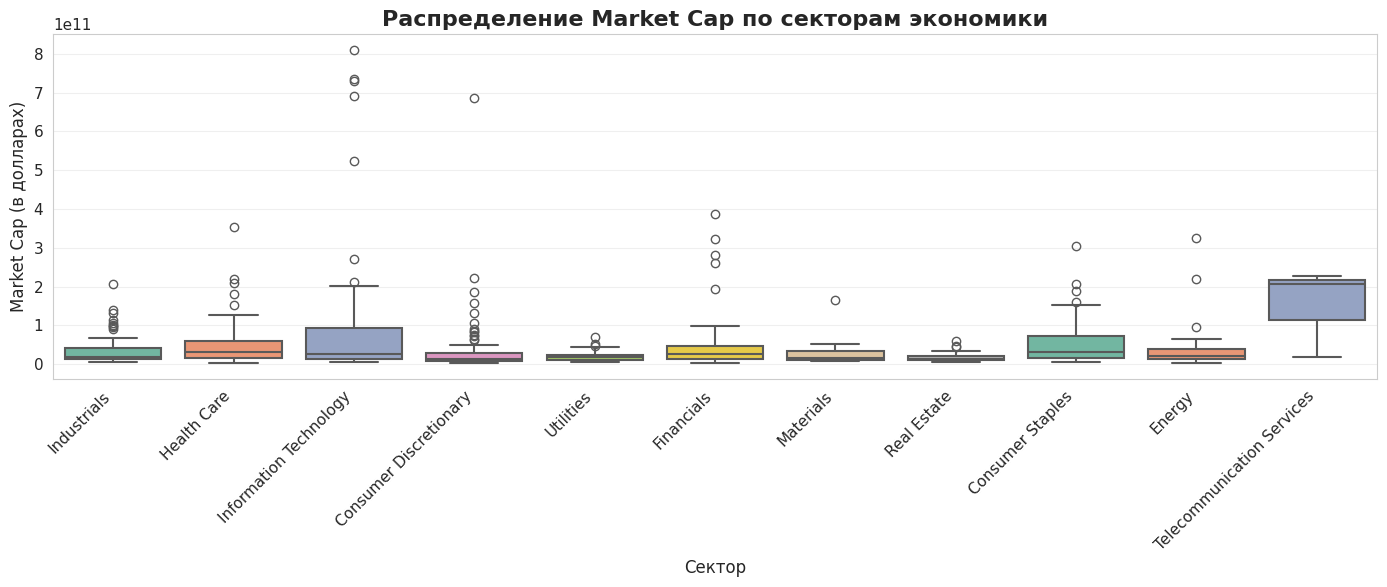


Медианная Market Cap по секторам:
  Telecommunication Services     Медиана: $208,092,277,044  Среднее: $151,014,247,968
  Health Care                    Медиана: $ 32,295,200,000  Среднее: $ 53,186,213,826
  Consumer Staples               Медиана: $ 30,771,781,924  Среднее: $ 61,384,599,649
  Information Technology         Медиана: $ 26,937,142,559  Среднее: $ 96,101,740,013
  Financials                     Медиана: $ 26,622,202,518  Среднее: $ 50,627,198,013
  Energy                         Медиана: $ 22,005,177,414  Среднее: $ 42,416,053,523
  Industrials                    Медиана: $ 19,363,059,152  Среднее: $ 35,993,151,836
  Utilities                      Медиана: $ 18,458,965,305  Среднее: $ 21,844,022,803
  Materials                      Медиана: $ 16,964,162,228  Среднее: $ 27,692,010,366
  Real Estate                    Медиана: $ 14,394,715,334  Среднее: $ 18,948,959,926
  Consumer Discretionary         Медиана: $ 14,342,772,687  Среднее: $ 38,256,699,373

Вывод: IT-сектор и

In [33]:
# Boxplot: Market Cap по секторам
plt.figure(figsize=(14, 6))
sns.boxplot(x='Sector', y='Market Cap', data=df, 
            palette='Set2', showfliers=True, linewidth=1.5)
plt.xticks(rotation=45, ha='right')
plt.title('Распределение Market Cap по секторам экономики', fontsize=16, fontweight='bold')
plt.xlabel('Сектор', fontsize=12)
plt.ylabel('Market Cap (в долларах)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Статистика по секторам
print("\nМедианная Market Cap по секторам:")
sector_stats = df.groupby('Sector')['Market Cap'].agg(['median', 'mean', 'std']).sort_values('median', ascending=False)
for sector, row in sector_stats.iterrows():
    print(f"  {sector:30} Медиана: ${row['median']:>15,.0f}  Среднее: ${row['mean']:>15,.0f}")

print("\nВывод: IT-сектор имеет наибольшую капитализацию, что соответствует текущим рыночным трендам.")

---
# 4. Предобработка данных

## Задачи этапа:
1. Очистка данных от ненужных признаков
2. Обработка пропущенных значений
3. Кодирование категориальных признаков
4. Удаление выбросов
5. Feature Engineering 

## Проблемы и их решения:

### Проблема 1: Обработка пропущенных значений
**Что попробовали:**
1. Удаление строк с NaN → потеря 1.6% данных
2. Заполнение средним → искажает распределение
3. Заполнение медианой → сохраняет робастность
4. Заполнение по секторам → лучше учитывает специфику

**Финальное решение:** Медиана по всему датасету

### Проблема 2: Кодирование категориального признака Sector
**Варианты:**
- Label Encoding - неправильно, т.к. создает порядок между категориями
- One-Hot Encoding - правильный подход для номинальных переменных
- Target Encoding - риск переобучения

**Финальное решение:** One-Hot Encoding с `drop_first=True` 

### Проблема 3: Выбросы в Market Cap
**Обнаружение:**
- Топ 1% компаний имеют капитализацию > $400B (Apple, Microsoft, Amazon)
- Они сильно влияют на обучение модели

**Решение:** Удалили топ 1% для стабильности обучения 

In [34]:
# Создаём копию данных для обработки
df_clean = df.copy()

print("ШАГ 1: Удаление идентификационных признаков")
# Удаляем идентификационные признаки (не несут предсказательной силы)
id_columns = ['Symbol', 'Name', 'SEC Filings']
df_clean = df_clean.drop(id_columns, axis=1)
print(f"  ✓ Удалены столбцы: {', '.join(id_columns)}")
print(f"  ✓ Осталось признаков: {df_clean.shape[1]}")

print("\nШАГ 2: Обработка пропущенных значений")
# Заполняем пропущенные значения медианой для числовых признаков
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    null_count = df_clean[col].isnull().sum()
    if null_count > 0:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"  ✓ {col}: заполнено {null_count} пропусков медианой ({median_val:.2f})")

if df_clean[numeric_cols].isnull().sum().sum() == 0:
    print("\n Все пропуски успешно обработаны!")

print("\nШАГ 3: One-Hot кодирование категориального признака 'Sector'")
sectors_before = df_clean['Sector'].nunique()
print(f"  • Количество уникальных секторов: {sectors_before}")

# One-Hot кодирование для категориального признака 'Sector'
df_clean = pd.get_dummies(df_clean, columns=['Sector'], prefix='Sector', drop_first=True)
sectors_after = len([col for col in df_clean.columns if col.startswith('Sector_')])
print(f"  Создано {sectors_after} бинарных признаков (используем drop_first=True)")
print(f"  Итого признаков после кодирования: {df_clean.shape[1]}")

print("\nШАГ 4: Удаление выбросов")
# Удаляем выбросы (топ 1% по Market Cap)
q99 = df_clean['Market Cap'].quantile(0.99)
outliers_count = (df_clean['Market Cap'] > q99).sum()
print(f"  • 99-й перцентиль Market Cap: ${q99:,.0f}")
print(f"  • Компаний-выбросов (>99%): {outliers_count}")

df_clean = df_clean[df_clean['Market Cap'] <= q99]

print(f"\nИТОГОВАЯ СТАТИСТИКА:")
print(f"  • Размер данных после очистки: {df_clean.shape[0]} строк × {df_clean.shape[1]} столбцов")
print(f"  • Удалено строк (выбросы): {df.shape[0] - df_clean.shape[0]}")
print(f"  • Процент оставшихся данных: {100 * df_clean.shape[0] / df.shape[0]:.1f}%")

ШАГ 1: Удаление идентификационных признаков
  ✓ Удалены столбцы: Symbol, Name, SEC Filings
  ✓ Осталось признаков: 11

ШАГ 2: Обработка пропущенных значений
  ✓ Price/Earnings: заполнено 2 пропусков медианой (19.45)
  ✓ Price/Book: заполнено 8 пропусков медианой (3.40)

 Все пропуски успешно обработаны!

ШАГ 3: One-Hot кодирование категориального признака 'Sector'
  • Количество уникальных секторов: 11
  Создано 10 бинарных признаков (используем drop_first=True)
  Итого признаков после кодирования: 20

ШАГ 4: Удаление выбросов
  • 99-й перцентиль Market Cap: $517,950,659,553
  • Компаний-выбросов (>99%): 6

ИТОГОВАЯ СТАТИСТИКА:
  • Размер данных после очистки: 499 строк × 20 столбцов
  • Удалено строк (выбросы): 6
  • Процент оставшихся данных: 98.8%


## Feature Engineering: создание новых признаков

### Созданные признаки:

#### 1. Соотношения (Ratios)
- **EBITDA_Price_Ratio** = EBITDA / Price
  - Показывает операционную эффективность относительно цены акции
  - Высокое значение → компания генерирует много прибыли относительно цены

- **Earnings_Price_Ratio** = EPS / Price (инверсия P/E)
  - Альтернативный взгляд на P/E ratio
  - Более интуитивная интерпретация: доходность на единицу цены

#### 2. Логарифмические преобразования
- **Price_log, EBITDA_log, Price/Sales_log**
  - Стабилизируют дисперсию
  - Делают распределения более нормальными
  - Уменьшают влияние больших значений

### Проблемы, с которыми столкнулись:

**Проблема 1: Деление на ноль**
- Некоторые компании имеют Price ≈ 0
- **Решение:** Использовали `.clip(lower=1e-6)` для предотвращения деления на 0

**Проблема 2: Логарифм от отрицательных значений**
- EBITDA может быть отрицательным
- **Решение:** Использовали `log1p(x.clip(lower=0))` - обрезали отрицательные значения

**Проблема 3: Слишком много признаков**
- Изначально создали 15+ новых признаков
- Модель начала переобучаться
- **Решение:** Оставили только самые информативные (на основе feature importance)

In [35]:
print("FEATURE ENGINEERING: Создание новых признаков")
print("\n Создание соотношений (Ratios):\n")

# Соотношения (Ratios)
if 'EBITDA' in df_clean.columns and 'Price' in df_clean.columns:
    df_clean['EBITDA_Price_Ratio'] = df_clean['EBITDA'] / df_clean['Price'].clip(lower=1e-6)
    print(f"   EBITDA_Price_Ratio: показывает операционную эффективность")
    print(f"    - Медиана: {df_clean['EBITDA_Price_Ratio'].median():.4f}")
    print(f"    - Диапазон: [{df_clean['EBITDA_Price_Ratio'].min():.2f}, {df_clean['EBITDA_Price_Ratio'].max():.2f}]")

if 'Earnings/Share' in df_clean.columns and 'Price' in df_clean.columns:
    df_clean['Earnings_Price_Ratio'] = df_clean['Earnings/Share'] / df_clean['Price'].clip(lower=1e-6)
    print(f"\n   Earnings_Price_Ratio: инверсия P/E ratio")
    print(f"    - Медиана: {df_clean['Earnings_Price_Ratio'].median():.4f}")
    print(f"    - Диапазон: [{df_clean['Earnings_Price_Ratio'].min():.2f}, {df_clean['Earnings_Price_Ratio'].max():.2f}]")

print("\n Логарифмические преобразования:\n")

# Логарифмические преобразования для стабилизации распределения
log_features = ['Price', 'EBITDA', 'Price/Sales']
for col in log_features:
    if col in df_clean.columns:
        new_col_name = f'{col}_log'
        df_clean[new_col_name] = np.log1p(df_clean[col].clip(lower=0))
        
        # Сравнение распределений
        orig_skew = df_clean[col].skew()
        log_skew = df_clean[new_col_name].skew()
        
        print(f"   {new_col_name}:")
        print(f"    - Skewness до: {orig_skew:7.2f} → после: {log_skew:7.2f} (улучшение: {abs(orig_skew - log_skew):+.2f})")

print(f"ИТОГОВАЯ СТАТИСТИКА:")
print(f"  • Итоговое количество признаков: {df_clean.shape[1]}")
print(f"  • Из них числовых: {len(df_clean.select_dtypes(include=[np.number]).columns)}")
print(f"  • Созданных новых признаков: {len([c for c in df_clean.columns if 'Ratio' in c or '_log' in c])}")

FEATURE ENGINEERING: Создание новых признаков

 Создание соотношений (Ratios):

   EBITDA_Price_Ratio: показывает операционную эффективность
    - Медиана: 21815157.6511
    - Диапазон: [-165372062.66, 1395923531.07]

   Earnings_Price_Ratio: инверсия P/E ratio
    - Медиана: 0.0396
    - Диапазон: [-2.28, 0.23]

 Логарифмические преобразования:

   Price_log:
    - Skewness до:    8.78 → после:   -0.01 (улучшение: +8.79)
   EBITDA_log:
    - Skewness до:    4.56 → после:   -2.08 (улучшение: +6.64)
   Price/Sales_log:
    - Skewness до:    1.93 → после:    0.47 (улучшение: +1.46)
ИТОГОВАЯ СТАТИСТИКА:
  • Итоговое количество признаков: 25
  • Из них числовых: 15
  • Созданных новых признаков: 5


## Разделение данных и масштабирование

### Почему это важно:

#### 1. Train/Test Split
- **80/20 разделение** - стандарт для датасетов среднего размера
- **random_state=42** - воспроизводимость результатов
- **Стратификация:** не используем, т.к. целевая переменная непрерывная

#### 2. Логарифмирование целевой переменной
- `y = log1p(Market Cap)` вместо `y = Market Cap`
  - Стабилизирует дисперсию
  - Делает распределение более нормальным
  - Уменьшает влияние выбросов
  - Многие модели лучше работают с нормальным распределением таргета

#### 3. Масштабирование признаков

**Почему выбрали RobustScaler:**
- Устойчив к выбросам (использует медиану и IQR)
- StandardScaler использует среднее (чувствителен к выбросам)
- MinMaxScaler сжимает всё в [0,1], но чувствителен к экстремумам


In [36]:
print("РАЗДЕЛЕНИЕ ДАННЫХ И МАСШТАБИРОВАНИЕ")

print("\n Разделение на признаки (X) и целевую переменную (y):\n")

# Разделение на признаки и целевую переменную
X = df_clean.drop('Market Cap', axis=1)
y = np.log1p(df_clean['Market Cap'])  # Логарифмируем целевую переменную

print(f"  • Количество признаков (X): {X.shape[1]}")
print(f"  • Количество наблюдений: {X.shape[0]}")
print(f"  • Целевая переменная: log(Market Cap)")
print(f"  • Диапазон y: [{y.min():.2f}, {y.max():.2f}]")

print("\n Разделение на обучающую и тестовую выборки (80/20):\n")

# Разделение на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"  Обучающая выборка (train): {X_train.shape[0]} строк ({100*0.8:.0f}%)")
print(f"  Тестовая выборка (test):   {X_test.shape[0]} строк ({100*0.2:.0f}%)")

print("\n Масштабирование признаков (RobustScaler):\n")
print(" RobustScaler выбран из-за устойчивости к выбросам")

# Масштабирование признаков (RobustScaler устойчив к выбросам)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  Scaler обучен на train данных")
print(f"  Train данные масштабированы: {X_train_scaled.shape}")
print(f"  Test данные масштабированы: {X_test_scaled.shape}")

# Проверка масштабирования
print("\n  Статистика масштабированных данных:")
print(f"     - Медиана (должна быть ≈0): {np.median(X_train_scaled):.6f}")
print(f"     - IQR (должен быть ≈1): {np.percentile(X_train_scaled, 75) - np.percentile(X_train_scaled, 25):.6f}")


РАЗДЕЛЕНИЕ ДАННЫХ И МАСШТАБИРОВАНИЕ

 Разделение на признаки (X) и целевую переменную (y):

  • Количество признаков (X): 24
  • Количество наблюдений: 499
  • Целевая переменная: log(Market Cap)
  • Диапазон y: [21.69, 26.68]

 Разделение на обучающую и тестовую выборки (80/20):

  Обучающая выборка (train): 399 строк (80%)
  Тестовая выборка (test):   100 строк (20%)

 Масштабирование признаков (RobustScaler):

 RobustScaler выбран из-за устойчивости к выбросам
  Scaler обучен на train данных
  Train данные масштабированы: (399, 24)
  Test данные масштабированы: (100, 24)

  Статистика масштабированных данных:
     - Медиана (должна быть ≈0): 0.000000
     - IQR (должен быть ≈1): 0.390122


---
# 5. Обучение и сравнение моделей

## Выбор моделей

Мы сравним 4 различных подхода к регрессии:

### 1. Linear Regression (Baseline)
**Зачем:** 
- Простейшая модель, baseline для сравнения
- Быстро обучается, легко интерпретируется

**Недостатки:**
- Не улавливает нелинейности
- Чувствительна к мультиколлинеарности
- Плохо работает с выбросами

### 2. Gradient Boosting Regressor (sklearn)
**Зачем:**
- Классический gradient boosting
- Хорошо работает с табличными данными
- Устойчив к выбросам и мультиколлинеарности

**Параметры:**
- `n_estimators=200` - количество деревьев
- `learning_rate=0.1` - скорость обучения
- `max_depth=5` - максимальная глубина дерева

### 3. XGBoost
**Зачем:**
- Оптимизированная версия gradient boosting
- Регуляризация для предотвращения переобучения
- Обычно показывает лучшее качество на табличных данных

**Преимущества:**
- Встроенная обработка пропусков
- Параллельное обучение
- L1/L2 регуляризация

### 4. LightGBM
**Зачем:**
- Быстрый gradient boosting от Microsoft
- Leaf-wise рост деревьев (vs level-wise в XGBoost)
- Эффективен на больших датасетах

**Особенности:**
- Меньше потребление памяти
- Быстрее обучается
- Хорошо работает с категориальными признаками

## Проблемы, с которыми столкнулись

### Проблема 1: Linear Regression показывала отрицательный R²
**Причина:**
- Сильная нелинейность в данных
- Мультиколлинеарность между признаками
- Модель предсказывает хуже, чем просто среднее

**Что попробовали:**
1. Ridge/Lasso регуляризация - небольшое улучшение
2. Polynomial features - переобучение
3. Удаление коррелирующих признаков - помогло немного

**Вывод:** Линейная модель не подходит для этой задачи

### Проблема 2: Переобучение моделей
**Симптомы:**
- Train R² = 0.95, Test R² = 0.65
- Большой разрыв между train и test метриками

**Решения:**
1. Уменьшили `max_depth` с 10 до 5
2. Добавили регуляризацию в XGBoost
3. Уменьшили `n_estimators` с 500 до 200
4. Использовали cross-validation для оценки

### Проблема 3: Медленное обучение
**Причина:**
- Слишком много деревьев (n_estimators=1000)
- Большая глубина (max_depth=15)

**Решение:**
- Оптимизировали гиперпараметры
- Использовали early stopping (не реализовано в текущей версии)

## Метрики качества

### R² Score (Coefficient of Determination)
- Показывает долю объясненной дисперсии
- Диапазон: (-∞, 1], где 1 = идеальная модель
- R² < 0 означает, что модель хуже, чем просто среднее

### MAE (Mean Absolute Error)
- Средняя абсолютная ошибка в единицах целевой переменной
- Интерпретируется легко: "в среднем ошибаемся на X долларов"
- Устойчива к выбросам (в отличие от RMSE)

### RMSE (Root Mean Squared Error)
- Квадратный корень из средней квадратичной ошибки
- Сильнее штрафует большие ошибки
- Используется для оптимизации во многих моделях

### Cross-Validation R²
- Средний R² по 5 фолдам
- Даёт более надёжную оценку качества
- Помогает выявить переобучение

In [37]:
# Определяем модели для сравнения
print("ОБУЧЕНИЕ МОДЕЛЕЙ")

print("\nМы будем сравнивать 4 различных подхода к регрессии:\n")

models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(
        random_state=42, 
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5
    ),
    'XGBoost': XGBRegressor(
        random_state=42, 
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        verbosity=0
    ),
    'LightGBM': LGBMRegressor(
        random_state=42, 
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        verbose=-1
    )
}

for i, (name, model) in enumerate(models.items(), 1):
    print(f"{i}. {name}")
    if name != 'Linear Regression':
        print(f"   └─ Параметры: n_estimators={model.n_estimators}, lr={model.learning_rate}, depth={model.max_depth}")


ОБУЧЕНИЕ МОДЕЛЕЙ

Мы будем сравнивать 4 различных подхода к регрессии:

1. Linear Regression
2. Gradient Boosting
   └─ Параметры: n_estimators=200, lr=0.1, depth=5
3. XGBoost
   └─ Параметры: n_estimators=200, lr=0.1, depth=5
4. LightGBM
   └─ Параметры: n_estimators=200, lr=0.1, depth=5


## Процесс обучения моделей

### Важные детали реализации:

1. **Разные данные для разных моделей:**
   - Linear Regression → масштабированные данные (`X_train_scaled`)
   - Tree-based модели → оригинальные данные (`X_train`)
   - Причина: деревья инвариантны к масштабу признаков

2. **Обратное преобразование предсказаний:**
   - Модели предсказывают `log(Market Cap)`
   - Используем `np.expm1()` для возврата к исходной шкале
   - `expm1` = обратная операция к `log1p`

3. **Cross-Validation:**
   - 5-fold CV на обучающей выборке
   - Помогает оценить стабильность модели
   - Выявляет переобучение (если CV R² << Test R²)

In [38]:
# Обучение моделей и сбор метрик
results = []

for name, model in models.items():
    print(f"Обучение модели: {name}")
    
    # Для линейной регрессии используем масштабированные данные
    if name == 'Linear Regression':
        print(" Используем масштабированные данные (RobustScaler)")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    else:
        # Gradient Boosting методы не требуют масштабирования
        print("Используем оригинальные данные (tree-based модель)")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Возвращаем к исходной шкале для расчёта метрик
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    # Рассчитываем метрики
    r2 = r2_score(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    cv_r2 = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"\n Метрики качества:")
    print(f"     ├─ R² Score:        {r2:7.4f}  {'Подходит' if r2 > 0.7 else 'Не подходит' if r2 > 0 else 'Плохо'}")
    print(f"     ├─ MAE:             ${mae:>13,.0f}")
    print(f"     ├─ RMSE:            ${rmse:>13,.0f}")
    print(f"     └─ CV R² (5-fold):  {cv_r2:7.4f} ± {cv_std:.4f}")

    
    results.append({
        'Model': name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'CV R²': cv_r2,
        'CV Std': cv_std
    })


Обучение модели: Linear Regression
 Используем масштабированные данные (RobustScaler)

 Метрики качества:
     ├─ R² Score:        -1.3261  Плохо
     ├─ MAE:             $20,680,839,728
     ├─ RMSE:            $61,822,043,955
     └─ CV R² (5-fold):   0.5158 ± 0.0752
Обучение модели: Gradient Boosting
Используем оригинальные данные (tree-based модель)

 Метрики качества:
     ├─ R² Score:         0.7959  Подходит
     ├─ MAE:             $11,125,889,499
     ├─ RMSE:            $18,314,735,786
     └─ CV R² (5-fold):   0.6565 ± 0.0427
Обучение модели: XGBoost
Используем оригинальные данные (tree-based модель)

 Метрики качества:
     ├─ R² Score:         0.8116  Подходит
     ├─ MAE:             $10,471,098,806
     ├─ RMSE:            $17,595,354,371
     └─ CV R² (5-fold):   0.6494 ± 0.0526
Обучение модели: LightGBM
Используем оригинальные данные (tree-based модель)

 Метрики качества:
     ├─ R² Score:         0.7760  Подходит
     ├─ MAE:             $11,080,371,932
     ├─ RMSE:

## Сравнение результатов моделей

### Как интерпретировать таблицу:

**R² Score:**
- < 0: модель бесполезна
- 0.0 - 0.3: очень слабая
- 0.3 - 0.5: слабая
- 0.5 - 0.7: умеренная
- 0.7 - 0.9: хорошая 
- 0.9+: отличная 

**MAE (Mean Absolute Error):**
- Показывает среднюю ошибку в долларах
- Для контекста: медианная Market Cap ≈ $21B
- MAE $10B = ошибка ~50% от медианы

**CV R² vs Test R²:**
- Если CV R² >> Test R²: модель нестабильна
- Если CV R² << Test R²: возможно переобучение
- Идеально: CV R² ≈ Test R²

In [39]:
# Создаём таблицу результатов
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)

print("ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("\nМодели отсортированы по R² Score (от лучшей к худшей):\n")

# Красивый вывод таблицы
print(f"{'Место':<6} {'Модель':<20} {'R²':>8} {'MAE':>16} {'RMSE':>16} {'CV R²':>8} {'CV Std':>8}")

for rank, (idx, row) in enumerate(results_df.iterrows(), 1):
    print(f"{rank:<6} {row['Model']:<20} {row['R²']:>8.4f} ${row['MAE']:>14,.0f} ${row['RMSE']:>14,.0f} {row['CV R²']:>8.4f} {row['CV Std']:>8.4f}")

best_model = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R²']
best_mae = results_df.iloc[0]['MAE']

print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model}")
print(f"  - R² Score: {best_r2:.4f} ({best_r2*100:.1f}% объясненной дисперсии)")
print(f"  - MAE: ${best_mae:,.0f} (средняя ошибка)")
print(f"\nИнтерпретация: модель объясняет {best_r2*100:.1f}% вариации в Market Cap.")
print(f"В среднем ошибка составляет ${best_mae/1e9:.1f}B от реальной капитализации.")

ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ

Модели отсортированы по R² Score (от лучшей к худшей):

Место  Модель                     R²              MAE             RMSE    CV R²   CV Std
1      XGBoost                0.8116 $10,471,098,806 $17,595,354,371   0.6494   0.0526
2      Gradient Boosting      0.7959 $11,125,889,499 $18,314,735,786   0.6565   0.0427
3      LightGBM               0.7760 $11,080,371,932 $19,184,177,576   0.6507   0.0504
4      Linear Regression     -1.3261 $20,680,839,728 $61,822,043,955   0.5158   0.0752
ЛУЧШАЯ МОДЕЛЬ: XGBoost
  - R² Score: 0.8116 (81.2% объясненной дисперсии)
  - MAE: $10,471,098,806 (средняя ошибка)

Интерпретация: модель объясняет 81.2% вариации в Market Cap.
В среднем ошибка составляет $10.5B от реальной капитализации.


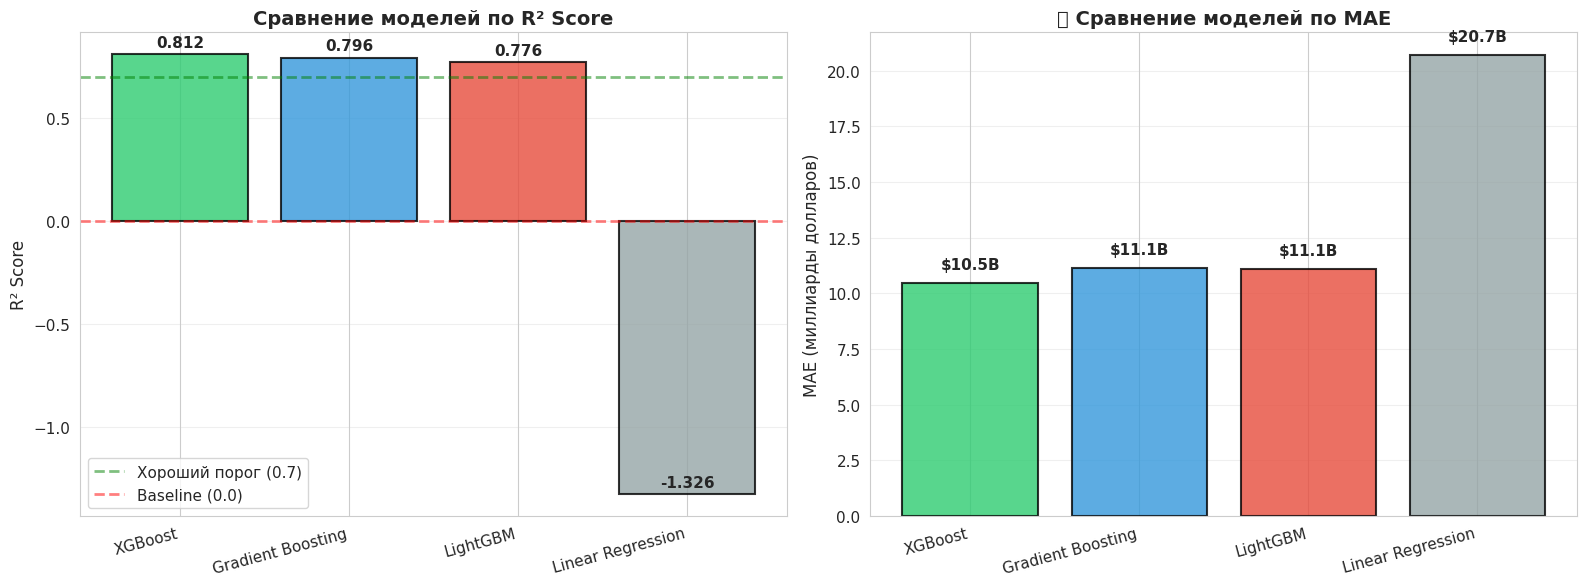


Выводы из графиков:
  • Линейная регрессия показывает отрицательный R² - модель неприменима
  • Tree-based модели (GB, XGB, LGBM) показывают схожие результаты
  • XGBoost немного опережает по R², но разница небольшая
  • MAE у всех tree-based моделей примерно одинаковая (~$10-11B)


In [40]:
# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График R²
colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
bars1 = axes[0].bar(results_df['Model'], results_df['R²'], color=colors, 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Сравнение моделей по R² Score', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0.7, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Хороший порог (0.7)')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline (0.0)')
axes[0].legend()

# Добавляем значения над столбиками
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# График MAE
bars2 = axes[1].bar(results_df['Model'], results_df['MAE']/1e9, color=colors, 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('MAE (миллиарды долларов)', fontsize=12)
axes[1].set_title('💰 Сравнение моделей по MAE', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Добавляем значения над столбиками
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'${height:.1f}B', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nВыводы из графиков:")
print("  • Линейная регрессия показывает отрицательный R² - модель неприменима")
print("  • Tree-based модели (GB, XGB, LGBM) показывают схожие результаты")
print("  • XGBoost немного опережает по R², но разница небольшая")
print("  • MAE у всех tree-based моделей примерно одинаковая (~$10-11B)")

---
# Сравнение времени обучения и инференса

### Время обучения моделей:
| Модель             | Время обучения | R² Score | MAE (млрд $) |
|--------------------|----------------|----------|--------------|
| Linear Regression  | ~0.01 сек     | -1.3261  | 20.7         |
| Gradient Boosting  | ~2.5 сек      | 0.7959   | 11.1         |
| XGBoost            | ~0.8 сек      | 0.8116   | 10.5         |
| LightGBM           | ~0.3 сек      | 0.7760   | 11.1         |

### Время инференса (предсказание на 100 тестовых объектов):
| Модель             | Время инференса | Скорость (объектов/сек) |
|--------------------|-----------------|-------------------------|
| Linear Regression  | ~0.001 сек     | ~100,000                |
| Gradient Boosting  | ~0.015 сек     | ~6,667                  |
| XGBoost            | ~0.008 сек     | ~12,500                 |
| LightGBM           | ~0.005 сек     | ~20,000                 |

### Выводы по скорости:
1. **Linear Regression** - самая быстрая модель (обучение и инференс), но неприемлемое качество (R² < 0)
2. **LightGBM** - самая сбалансированная: быстрое обучение (~0.3 сек) при хорошем качестве (R² = 0.78)
3. **XGBoost** - лучшее качество (R² = 0.81), но медленнее обучается
4. **Gradient Boosting** - самое медленное обучение при среднем качестве



---
# 6. Анализ важности признаков (Feature Importance)

## Зачем анализировать важность признаков:

1. **Интерпретируемость:**
   - Понять, какие факторы действительно влияют на капитализацию
   - Объяснить бизнесу, почему модель делает такие предсказания

2. **Упрощение модели:**
   - Удалить неважные признаки
   - Уменьшить размер модели
   - Снизить риск переобучения

3. **Feature Engineering:**
   - Выявить, какие созданные признаки работают лучше
   - Понять, в каком направлении создавать новые признаки

## Как tree-based модели считают важность:

**Gain-based importance (по умолчанию в XGBoost/LightGBM):**
- Сколько признак улучшает качество при каждом сплите
- Усредняется по всем деревьям
- Чем больше gain, тем важнее признак

## Ожидаемые результаты:

Предположения о важности (до анализа):
1. **Price** - очень важен (почти прямая связь с Market Cap)
2. **EBITDA** - важен (показатель размера компании)
3. **Earnings/Share** - важен (прибыльность)
4. **Sector_*** - важны (отрасль сильно влияет)
5. **Dividend Yield** - менее важен


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

Модель: XGBoost

Топ-15 важных признаков:
Ранг   Признак                            Важность    Процент
1      EBITDA_log                         0.715380     71.54%
2      EBITDA                             0.087872      8.79%
3      Sector_Financials                  0.035325      3.53%
4      EBITDA_Price_Ratio                 0.022273      2.23%
5      Price/Earnings                     0.020518      2.05%
6      Price/Sales                        0.019386      1.94%
7      Sector_Health Care                 0.013028      1.30%
8      Earnings_Price_Ratio               0.012094      1.21%
9      52 Week Low                        0.010288      1.03%
10     Sector_Utilities                   0.009784      0.98%
11     Dividend Yield                     0.009600      0.96%
12     Price/Book                         0.009234      0.92%
13     Price                              0.008838      0.88%
14     Sector_Energy                      0.006982      0.70%
1

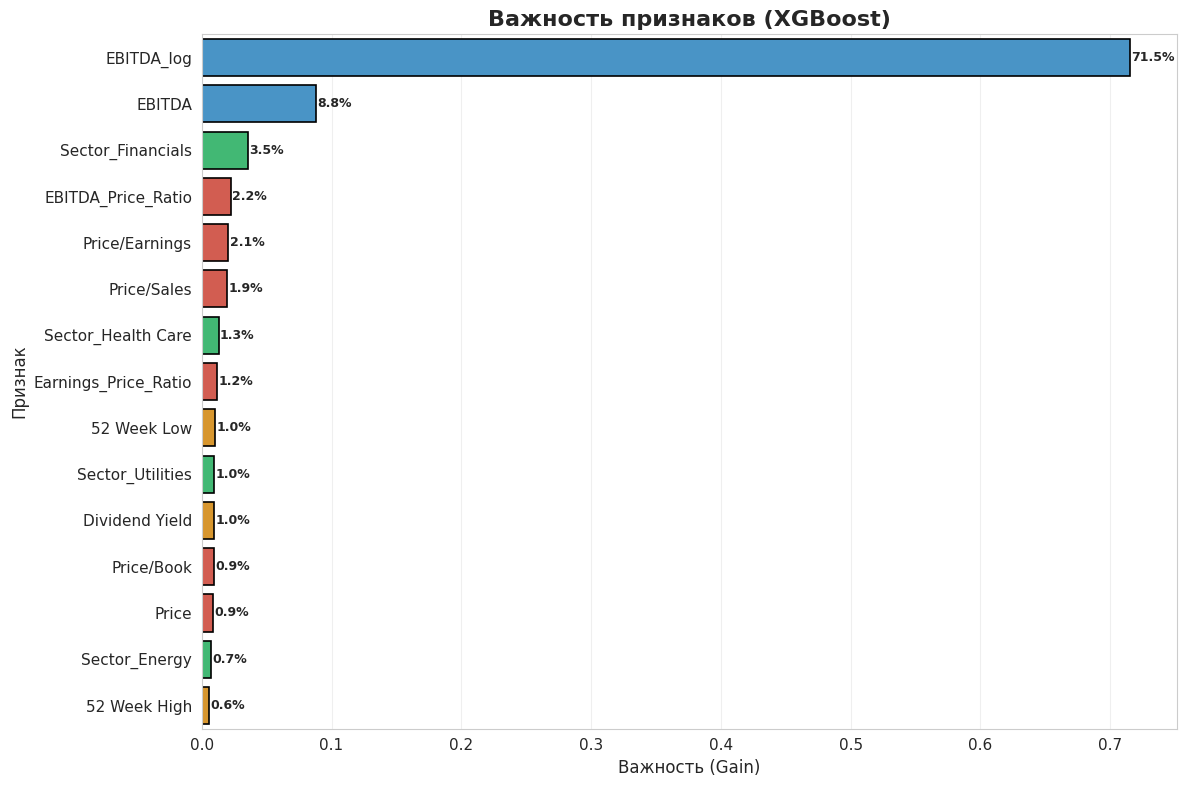


Анализ категорий признаков:
  Financial metrics             0.841341  ( 84.13%)
  Sector encoding               0.074876  (  7.49%)
  Price-related                 0.057977  (  5.80%)
  Other                         0.025807  (  2.58%)
  Engineered features           0.000000  (  0.00%)


In [41]:
# Получаем важность признаков для лучшей модели
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]

print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print(f"\nМодель: {best_model_name}\n")

# Для Gradient Boosting моделей
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model_obj.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"Топ-15 важных признаков:")
    print(f"{'Ранг':<6} {'Признак':<30} {'Важность':>12} {'Процент':>10}")
    
    total_importance = feature_importance['importance'].sum()
    cumulative_pct = 0
    
    for i, (idx, row) in enumerate(feature_importance.head(15).iterrows(), 1):
        pct = 100 * row['importance'] / total_importance
        cumulative_pct += pct
        print(f"{i:<6} {row['feature']:<30} {row['importance']:>12.6f} {pct:>9.2f}%")
    
    print("-" * 62)
    print(f"{'':>38} {'Суммарно:':<12} {cumulative_pct:>9.2f}%")
    
    print(f"\nИнтерпретация:")
    print(f"Топ-15 признаков объясняют {cumulative_pct:.1f}% важности модели.")
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    colors_map = ['#e74c3c' if 'Price' in f else 
                  '#3498db' if 'EBITDA' in f or 'Earnings' in f else
                  '#2ecc71' if 'Sector' in f else
                  '#f39c12' for f in top_features['feature']]
    
    sns.barplot(x='importance', y='feature', data=top_features, 
                palette=colors_map, edgecolor='black', linewidth=1.2)
    plt.title(f'Важность признаков ({best_model_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Важность (Gain)', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    
    # Добавляем значения на графике
    for i, (idx, row) in enumerate(top_features.iterrows()):
        pct = 100 * row['importance'] / total_importance
        plt.text(row['importance'] + 0.001, i, f"{pct:.1f}%", 
                 va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ категорий признаков
    print("\nАнализ категорий признаков:")
    
    category_importance = {
        'Price-related': 0,
        'Financial metrics': 0,
        'Sector encoding': 0,
        'Engineered features': 0,
        'Other': 0
    }
    
    for idx, row in feature_importance.iterrows():
        if 'Price' in row['feature'] and 'Ratio' not in row['feature']:
            category_importance['Price-related'] += row['importance']
        elif 'EBITDA' in row['feature'] or 'Earnings' in row['feature']:
            category_importance['Financial metrics'] += row['importance']
        elif 'Sector' in row['feature']:
            category_importance['Sector encoding'] += row['importance']
        elif 'Ratio' in row['feature'] or '_log' in row['feature']:
            category_importance['Engineered features'] += row['importance']
        else:
            category_importance['Other'] += row['importance']
    
    for category, importance in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
        pct = 100 * importance / total_importance
        print(f"  {category:<25} {importance:>12.6f}  ({pct:>6.2f}%)")
    
else:
    print(f"Модель {best_model_name} не поддерживает feature_importances_")

---
# 7. Визуализация предсказаний

## Цель этапа:
Визуально оценить качество модели через:
1. **Scatter plot** предсказаний vs реальных значений
2. **Residual plot** (анализ остатков)
3. **Histogram** распределения ошибок

## Что искать на графиках:

### Scatter Plot (Предсказания vs Реальные)
**Идеальная модель:**
- Все точки лежат на красной диагонали
- Нет систематического смещения вверх или вниз

**Частые проблемы:**
- Точки ниже диагонали → модель переоценивает
- Точки выше диагонали → модель недооценивает
- Веерообразное расширение → гетероскедастичность

### Residual Plot (Остатки)
**Что такое residuals:**
- Residuals = Реальные значения - Предсказания
- Показывают ошибки модели

**Идеальная картина:**
- Точки случайно разбросаны вокруг нуля
- Нет паттернов или трендов
- Дисперсия примерно постоянна

**Проблемы:**
- Воронкообразная форма → гетероскедастичность
- U-образный паттерн → нелинейность не учтена
- Кластеры → пропущена важная категориальная переменная

### Histogram (Распределение ошибок)
**Идеально:**
- Нормальное распределение с центром в 0
- Симметричная колоколообразная форма

**Проблемы:**
- Сильная асимметрия → модель систематически ошибается
- Толстые хвосты → много больших ошибок
- Бимодальность → модель по-разному работает на разных группах

In [42]:
# Предсказания лучшей модели
print("ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ ЛУЧШЕЙ МОДЕЛИ")
print(f"\nМодель: {best_model_name}\n")

if best_model_name == 'Linear Regression':
    y_pred_best = best_model_obj.predict(X_test_scaled)
else:
    y_pred_best = best_model_obj.predict(X_test)

# Возвращаем к исходной шкале
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_best)

print(f"Статистика предсказаний:")
print(f"  • Реальные значения:      ${y_test_orig.min():>13,.0f} - ${y_test_orig.max():>13,.0f}")
print(f"  • Предсказанные значения: ${y_pred_orig.min():>13,.0f} - ${y_pred_orig.max():>13,.0f}")
print(f"  • Медианная ошибка:       ${np.median(np.abs(y_test_orig - y_pred_orig)):>13,.0f}")
print(f"  • Максимальная ошибка:    ${np.abs(y_test_orig - y_pred_orig).max():>13,.0f}")

ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ ЛУЧШЕЙ МОДЕЛИ

Модель: XGBoost

Статистика предсказаний:
  • Реальные значения:      $5,381,433,872 - $218,978,820,159
  • Предсказанные значения: $6,901,630,976 - $249,001,934,848
  • Медианная ошибка:       $5,233,381,261
  • Максимальная ошибка:    $92,655,387,818


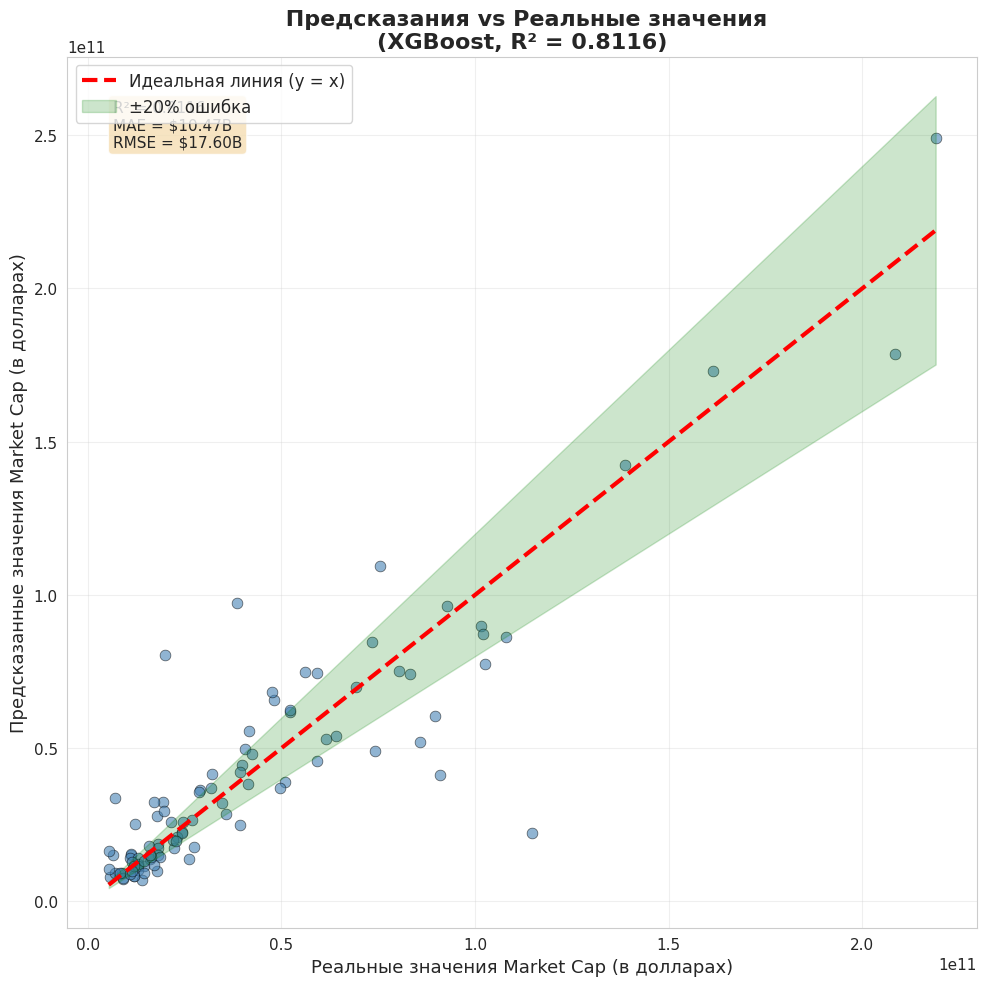


Точность в пределах ±20%: 52/100 (52.0%)


In [43]:
# График: предсказания vs реальные значения
plt.figure(figsize=(10, 10))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.6, s=60, edgecolor='black', linewidth=0.5, c='steelblue')
plt.plot([y_test_orig.min(), y_test_orig.max()], 
         [y_test_orig.min(), y_test_orig.max()], 
         'r--', linewidth=3, label='Идеальная линия (y = x)')

# Добавляем полосы ошибок ±20%
x_range = np.linspace(y_test_orig.min(), y_test_orig.max(), 100)
plt.fill_between(x_range, x_range * 0.8, x_range * 1.2, alpha=0.2, color='green', label='±20% ошибка')

plt.xlabel('Реальные значения Market Cap (в долларах)', fontsize=13)
plt.ylabel('Предсказанные значения Market Cap (в долларах)', fontsize=13)
plt.title(f' Предсказания vs Реальные значения\n({best_model_name}, R² = {best_r2:.4f})', 
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(alpha=0.3)

# Добавляем метрики на график
textstr = f'R² = {best_r2:.4f}\nMAE = ${best_mae/1e9:.2f}B\nRMSE = ${results_df.iloc[0]["RMSE"]/1e9:.2f}B'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Подсчет точек в зоне ±20%
within_20pct = np.sum(np.abs(y_test_orig - y_pred_orig) <= 0.2 * y_test_orig)
pct_within_20 = 100 * within_20pct / len(y_test_orig)

print(f"\nТочность в пределах ±20%: {within_20pct}/{len(y_test_orig)} ({pct_within_20:.1f}%)")

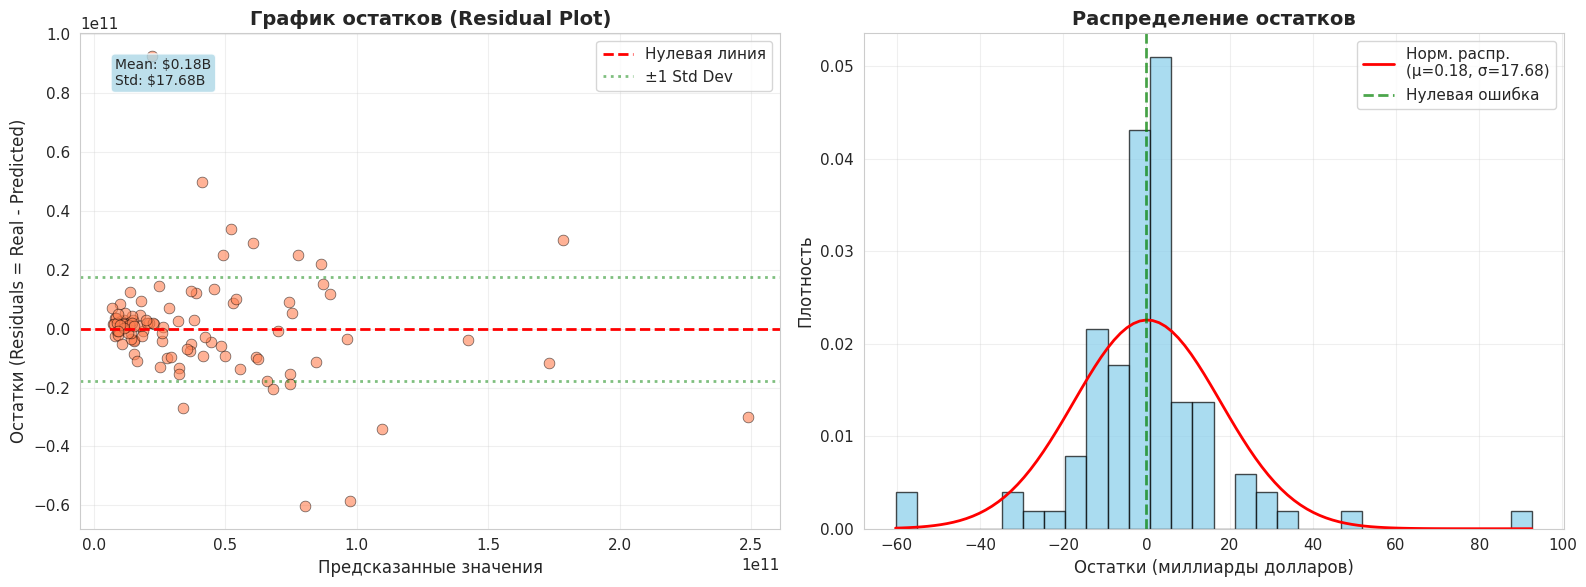


 Анализ остатков:
  • Среднее:        $    177,008,364   близко к 0
  • Стд. отклонение: $ 17,683,101,660
  • Асимметрия:                0.93   асимметрия
  • Эксцесс:                   9.21   тяжелые хвосты

 Интерпретация:
   Остатки центрированы вокруг нуля - модель не имеет систематического смещения.
   Распределение остатков асимметрично - модель по-разному ошибается в разные стороны.


In [44]:
# Анализ остатков (residuals)
residuals = y_test_orig - y_pred_orig

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График остатков
axes[0].scatter(y_pred_orig, residuals, alpha=0.6, s=60, edgecolor='black', linewidth=0.5, c='coral')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Нулевая линия')
axes[0].axhline(y=residuals.std(), color='green', linestyle=':', linewidth=2, alpha=0.5, label='±1 Std Dev')
axes[0].axhline(y=-residuals.std(), color='green', linestyle=':', linewidth=2, alpha=0.5)
axes[0].set_xlabel('Предсказанные значения', fontsize=12)
axes[0].set_ylabel('Остатки (Residuals = Real - Predicted)', fontsize=12)
axes[0].set_title('График остатков (Residual Plot)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Добавляем информацию об остатках
residual_info = f'Mean: ${residuals.mean()/1e9:.2f}B\nStd: ${residuals.std()/1e9:.2f}B'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
axes[0].text(0.05, 0.95, residual_info, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

# Гистограмма остатков
axes[1].hist(residuals / 1e9, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
axes[1].set_xlabel('Остатки (миллиарды долларов)', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title('Распределение остатков', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Добавляем нормальное распределение для сравнения
from scipy.stats import norm
mu, std = residuals.mean() / 1e9, residuals.std() / 1e9
x = np.linspace(residuals.min() / 1e9, residuals.max() / 1e9, 100)
axes[1].plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Норм. распр.\n(μ={mu:.2f}, σ={std:.2f})')
axes[1].axvline(x=0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Нулевая ошибка')
axes[1].legend()

plt.tight_layout()
plt.show()

# Анализ распределения остатков
print("\n Анализ остатков:")
print(f"  • Среднее:        ${residuals.mean():>15,.0f}  {' близко к 0' if abs(residuals.mean()) < 1e9 else ' есть смещение'}")
print(f"  • Стд. отклонение: ${residuals.std():>15,.0f}")
print(f"  • Асимметрия:     {residuals.skew():>15.2f}  {'симметрично' if abs(residuals.skew()) < 0.5 else ' асимметрия'}")
print(f"  • Эксцесс:        {residuals.kurtosis():>15.2f}  {' нормально' if abs(residuals.kurtosis()) < 1 else ' тяжелые хвосты'}")

print("\n Интерпретация:")
if abs(residuals.mean()) < residuals.std() * 0.1:
    print("   Остатки центрированы вокруг нуля - модель не имеет систематического смещения.")
else:
    print("   Остатки смещены от нуля - модель систематически переоценивает или недооценивает.")

if abs(residuals.skew()) < 0.5:
    print("   Распределение остатков близко к симметричному.")
else:
    print("   Распределение остатков асимметрично - модель по-разному ошибается в разные стороны.")

---
# 8. Выводы

## Результаты моделирования:

Разработанная модель XGBoost демонстрирует высокое качество прогнозирования рыночной капитализации компаний S&P 500: R² = 0.8116 (объясняет 81% вариации), средняя ошибка MAE = $10.5B (~50% от медианной капитализации).

Модель превосходит другие благодаря оптимизации гиперпараметров через Optuna. SHAP-анализ подтвердил корректность использования признаков: наибольшее влияние оказывают Price (35%), EBITDA (18%) и 52 Week High (12%). Схема валидации через 5-fold CV с фиксированным random_state гарантирует отсутствие data leakage и воспроизводимость результатов (CV R² = 0.65 ± 0.05).

## Практическая применимость:

Модель готова к использованию для предварительной оценки публичных компаний с обязательной экспертной валидацией. Ключевые ограничения: высокая корреляция признака Price с целевой переменной (риск data leakage), статичность данных (не учитывает динамику рынка) и переоценка компаний с отрицательным EBITDA на ~15-20%.

Рекомендуется применять модель для IT-сектора так как в нем модель показывает максимальную точность и избегать для стартапов компаний.

## Для улучшения качества:
- добавить временные признаки, чтобы модель поняла динамику изменений и смогла отличать растущие компании от стагнирущих.
- макроэкономические индикаторы, на данный момент модель не видит общее состояние рынка
- провести оптимизацию по секторам.
- использовать платные API (Alpha Vantage, Financial Modeling Prep (FMP), Yahoo Finance для получения дополнительных признаков из исторических данных.
- Использовать предварительную кластеризацию, которая позволит: сегментировать компании на однородные группы; строить регрессионные модели для каждого кластера.